# Self-Study 11: Strategic Network Formation

## Introduction

In this tutorial, you will learn how to:
1. Implement the **Connections Model** (Jackson–Wolinsky)
3. Test for **pairwise stability** in networks
4. Simulate **myopic dynamics** where agents form and sever links


In [35]:
import networkx as nx
import matplotlib.pyplot as plt
import random

## The Connections Model: Formal Definition

### Network and Utility

* Network: Undirected graph $G = (N, E)$ with $n$ nodes
* Each agent $i$ obtains utility:

$$
u_i(G) = \sum_{j \neq i} \delta^{d_{ij}(G)} - c \cdot d_i(G)
$$

where:
* $d_{ij}(G)$ = shortest-path distance between $i$ and $j$ (contribution is 0 if $j$ unreachable)
* $d_i(G)$ = degree of $i$ (number of direct links)
* $\delta \in (0,1)$ = benefit decay per distance step
* $c > 0$ = cost per link

**Intuition**: Direct neighbors give benefit $\delta$, neighbors at distance 2 give $\delta^2$, etc. Each link costs $c$ to maintain.

### Pairwise Stability

A network $G$ is **pairwise stable** if:

1. **No profitable deletion**: For every edge $(i,j) \in E$, neither endpoint strictly gains from deleting it:
   $$u_i(G) \geq u_i(G - ij) \quad \text{and} \quad u_j(G) \geq u_j(G - ij)$$

2. **No mutually profitable addition**: For every missing edge $(i,j) \notin E$, it's not the case that both strictly gain:
   $$\neg\big( u_i(G+ij) > u_i(G) \text{ and } u_j(G+ij) > u_j(G) \big)$$


### Welfare

$$
W(G) = \sum_{i \in N} u_i
$$

## Section 1: Utility and Welfare

### Task 1: Implement the Utility and Welfare Function

Implement `compute_utility(G, node, delta, c)` that calculates a node's utility according to the formula above.

**Hints:**
- Use `nx.shortest_path_length(G, source=node)` to get distances to all reachable nodes
- This returns a dictionary `{target: distance}` (unreachable nodes don't appear)

In [36]:
def compute_utility(G, node, delta, c):
    
    utility = 0 
    
    for neighbor in G.neighbors(node):
        if neighbor != node:
            utility += delta**nx.shortest_path_length(G, node, neighbor) - c*nx.degree(G, node)
    return utility
    


In [37]:
def welfare(G, delta, c):
    welfare = 0
    for node in G.nodes():
        welfare += compute_utility(G, node, delta, c)
    return welfare
    

### Test the utility function

Let's test on a simple network:

In [38]:
# CODE PROVIDED
G_test = nx.star_graph(2)

for node in G_test.nodes():
    util = compute_utility(G_test, node, delta=0.4, c=0.35)
    print(f"Node {node}: degree={G_test.degree(node)}, utility={util:.3f}")
print(f"Welfare of the network: {welfare(G_test, delta=0.4, c=0.35):.3f}")

Node 0: degree=2, utility=-0.600
Node 1: degree=1, utility=0.050
Node 2: degree=1, utility=0.050
Welfare of the network: -0.500


## Section 2: Pairwise Stability Conditions

### Task 2: Evaluate Edge Changes

Implement `evaluate_edge_change(G, i, j, delta, c)` that determines if nodes `i` and `j` want to change their link status.

Pairwise Stability:
- If edge exists and **either** endpoint gains: return `"cut"`
- If edge missing, add **both** endpoints gain: return `"add"`
- Otherwise: return `"keep"`

*Important*: Create a copy `G_new = G.copy()` to test the counterfactual (i.e., adding, cutting)

**Hint:**

- Use `G.has_edge(i, j)` to check if edge exists

In [39]:
def evaluate_edge_change(G, i, j, delta, c):
    
    # return one of the strings: "cut", "add", or "keep"
    
    G_new = G.copy()
    
    #check for possible edge removal
    if G_new.has_edge(i, j):
        G_new.remove_edge(i, j)
        welfare_after_cut = welfare(G_new, delta, c)
        welfare_before = welfare(G, delta, c)
        
        if welfare_after_cut > welfare_before:
            return "cut"
        else:
            return "keep"
    
    if not G_new.has_edge(i, j):
        G_new.add_edge(i, j)
        welfare_after_add = welfare(G_new, delta, c)
        welfare_before = welfare(G, delta, c)
        
        if welfare_after_add > welfare_before:
            return "add"
        else:
            return "keep"
    

### Test the edge evaluation function

Let's test this on a simple case:

In [40]:
# CODE PROVIDED
G_path = nx.star_graph(2)
delta, c = 0.4, 0.5  # cost higher than benefit -> cutting expected

print("Star graph with 3 nodes 1-0-2 (not stable under these parameters)")
action_01 = evaluate_edge_change(G_path, 0, 1, delta, c)
print(f"Existing Edge (0,1): '{action_01}'")
action_02 = evaluate_edge_change(G_path, 1, 2, delta, c)
print(f"Potential Edge (1,2): '{action_02}'")

Star graph with 3 nodes 1-0-2 (not stable under these parameters)
Existing Edge (0,1): 'cut'
Potential Edge (1,2): 'keep'


### Task 3: Check Pairwise Stability

Implement `is_pairwise_stable(G, delta, c)`, return `True` if it is `False` otherwise.


In [41]:
def is_pairwise_stable(G, delta, c):
    for i in G.nodes():
        for j in G.nodes():
            if i != j:
                action = evaluate_edge_change(G, i, j, delta, c)
                if action != "keep":
                    print(f"Graph is not pairwise stable because of nodes {i} and {j} (action: {action})")
                    return False
                else:
                    print(f"Nodes {i} and {j} are stable (action: {action})")
    return True
    

### Test stability on simple networks

In [42]:
# CODE PROVIDED
K_n = nx.complete_graph(9)
delta = 0.5
c = delta - delta**2 - 0.01  # K_n is stable in this case
print(f"Is K_9 stable? {is_pairwise_stable(K_n, delta=delta, c=c)}")

c = delta - delta**2 + 0.01  # S_n is not stable
print(f"Is K_9 stable? {is_pairwise_stable(K_n, delta=delta, c=c)}")

Graph is not pairwise stable because of nodes 0 and 1 (action: cut)
Is K_9 stable? False
Graph is not pairwise stable because of nodes 0 and 1 (action: cut)
Is K_9 stable? False


## Section 3: Dynamics Simulation

Now we'll simulate the process where agents form and sever links based on utility gains.

### Task 4: Implement One Update Step

Implement `update_step(G, delta, c)` that applies one link change per iteration.

**Approach:**
- Check pairs wanting to change their link status ("cut" or "add") using the `evaluate_edge_change` function you wrote above.
- Select one pair and apply the change ("add" or "cut")
- Return `True` if a change was made, `False` otherwise.


In [43]:
def update_step(G, delta, c):
    for i in G.nodes():
        for j in G.nodes():
            if i != j:
                action = evaluate_edge_change(G, i, j, delta, c)
                if action == "cut":
                    G.remove_edge(i, j)
                    print(f"Edge ({i}, {j}) removed.")
                    return True
                elif action == "add":
                    G.add_edge(i, j)
                    print(f"Edge ({i}, {j}) added.")
                    return True
    return False

### Run Full Simulation (Code Provided)

In [44]:
# CODE PROVIDED
def simulate_network_formation(delta, c, n=None, G_init=None, max_iter=10000):
    assert n is not None or G_init is not None, "Either n or G_init must be provided."

    if G_init is None:
        G = nx.empty_graph(n)
    else:
        G = G_init.copy()

    history = [(0, G.number_of_edges(), welfare(G, delta, c))]

    for iteration in range(1, max_iter):
        changed = update_step(G, delta, c)

        if changed:
            current_welfare = welfare(G, delta, c)
            history.append((iteration, G.number_of_edges(), current_welfare))
        else:
            # No pair wants to change - network is pairwise stable
            break
    else:
        print(f"Reached max iterations ({max_iter})")

    return G, history

In [45]:
# CODE PROVIDED
def theoretical_max_welfare(c, delta, n):
    W_complete = n * (n - 1) * (delta - c)
    W_star = (n - 1) * (2 * delta + (n - 2) * delta**2 - 2 * c)
    W_empty = 0

    # Efficiency cutoffs
    cutoff_complete = delta - delta**2
    cutoff_star = delta + ((n - 2) / 2) * delta**2

    # Pick efficient network
    if c < cutoff_complete:
        return W_complete
    elif c < cutoff_star:
        return W_star
    else:
        return W_empty

In [46]:
# CODE PROVIDED
def plot_simulation(delta, c, n=None, G_init=None):
    """Run network formation simulation and visualize results."""

    assert n is not None or G_init is not None, "Either n or G_init must be provided."
    if n is None and G_init is not None:
        n = G_init.number_of_nodes()

    # Run simulation
    G_final, history = simulate_network_formation(delta, c, n=n, G_init=G_init)
    is_stable = is_pairwise_stable(G_final, delta, c)

    # Extract data from history
    iterations, num_edges, welfare_values = zip(*history)

    # Compute efficiency
    final_welfare = welfare_values[-1]
    max_welfare = theoretical_max_welfare(c, delta, n)
    efficiency_ratio = final_welfare / max_welfare if max_welfare > 0 else 0

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes = axes.flatten()

    if G_init is None:
        G_init = nx.empty_graph(n)

    axes[0].set_title("Starting Network")
    pos = nx.spring_layout(G_init, seed=42)
    nx.draw(G_init, pos, ax=axes[0], with_labels=True)

    pos = nx.spring_layout(G_final, seed=42)
    nx.draw(G_final, pos, ax=axes[1], with_labels=True)
    axes[1].set_title(f"Stable: {is_stable} | Edges: {G_final.number_of_edges()}")

    axes[2].plot(iterations, num_edges, "o-", linewidth=2, color="#3498db")
    axes[2].set_ylabel("Number of Edges")
    axes[2].set_title("Edge Evolution")

    axes[3].plot(iterations, welfare_values, "o-", label="Actual")
    axes[3].axhline(y=max_welfare, color="black", label=f"Max = {max_welfare:.2f}")
    axes[3].set_ylabel("Total Welfare")
    axes[3].set_title(f"Welfare Evolution (Efficiency: {efficiency_ratio:.1%})")
    axes[3].legend()

    plt.tight_layout()
    plt.show()

Edge (0, 1) added.
Edge (2, 3) added.
Edge (4, 5) added.
Nodes 0 and 1 are stable (action: keep)
Nodes 0 and 2 are stable (action: keep)
Nodes 0 and 3 are stable (action: keep)
Nodes 0 and 4 are stable (action: keep)
Nodes 0 and 5 are stable (action: keep)
Nodes 1 and 0 are stable (action: keep)
Nodes 1 and 2 are stable (action: keep)
Nodes 1 and 3 are stable (action: keep)
Nodes 1 and 4 are stable (action: keep)
Nodes 1 and 5 are stable (action: keep)
Nodes 2 and 0 are stable (action: keep)
Nodes 2 and 1 are stable (action: keep)
Nodes 2 and 3 are stable (action: keep)
Nodes 2 and 4 are stable (action: keep)
Nodes 2 and 5 are stable (action: keep)
Nodes 3 and 0 are stable (action: keep)
Nodes 3 and 1 are stable (action: keep)
Nodes 3 and 2 are stable (action: keep)
Nodes 3 and 4 are stable (action: keep)
Nodes 3 and 5 are stable (action: keep)
Nodes 4 and 0 are stable (action: keep)
Nodes 4 and 1 are stable (action: keep)
Nodes 4 and 2 are stable (action: keep)
Nodes 4 and 3 are stabl

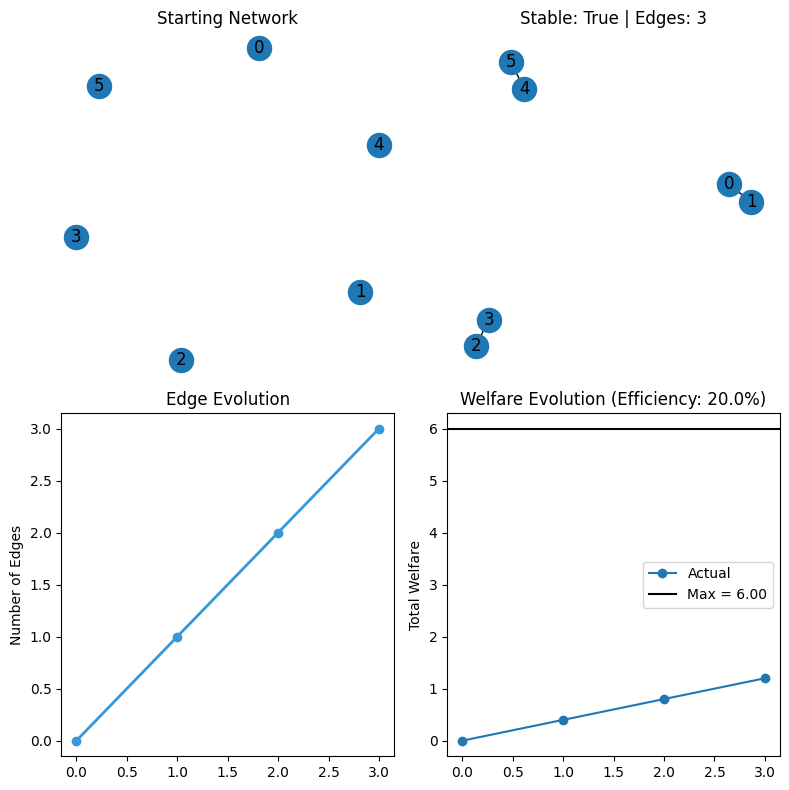

In [47]:
plot_simulation(delta=0.4, c=0.2, n=6)

### Task 5: Look at evolution of possible systems


Run a few experiments simulating using `plot_simulation`

1. Starting from empty network (i.e. not provide `G_init` only `n`) and see how the network evolves, based on on the thresholds we saw in class (also in `theoretical_max_welfare()` here in case).
    - e.g., $c>\delta-\delta^2$
2. Starting from some other networks structures: What networks emerge that are stable.
3. Do networks always end up looking like $\emptyset$, $K_n$, $S_n$, if not why is that?


```python
# possible start networks G_init to try
test_graph = nx.barbell_graph(3, 1)
test_graph = nx.ring_of_cliques(3, 4)
test_graph = nx.balanced_tree(r=2, h=3)
```



Edge (0, 1) added.
Edge (2, 3) added.
Edge (4, 5) added.
Edge (6, 7) added.
Edge (8, 9) added.
Nodes 0 and 1 are stable (action: keep)
Nodes 0 and 2 are stable (action: keep)
Nodes 0 and 3 are stable (action: keep)
Nodes 0 and 4 are stable (action: keep)
Nodes 0 and 5 are stable (action: keep)
Nodes 0 and 6 are stable (action: keep)
Nodes 0 and 7 are stable (action: keep)
Nodes 0 and 8 are stable (action: keep)
Nodes 0 and 9 are stable (action: keep)
Nodes 1 and 0 are stable (action: keep)
Nodes 1 and 2 are stable (action: keep)
Nodes 1 and 3 are stable (action: keep)
Nodes 1 and 4 are stable (action: keep)
Nodes 1 and 5 are stable (action: keep)
Nodes 1 and 6 are stable (action: keep)
Nodes 1 and 7 are stable (action: keep)
Nodes 1 and 8 are stable (action: keep)
Nodes 1 and 9 are stable (action: keep)
Nodes 2 and 0 are stable (action: keep)
Nodes 2 and 1 are stable (action: keep)
Nodes 2 and 3 are stable (action: keep)
Nodes 2 and 4 are stable (action: keep)
Nodes 2 and 5 are stable 

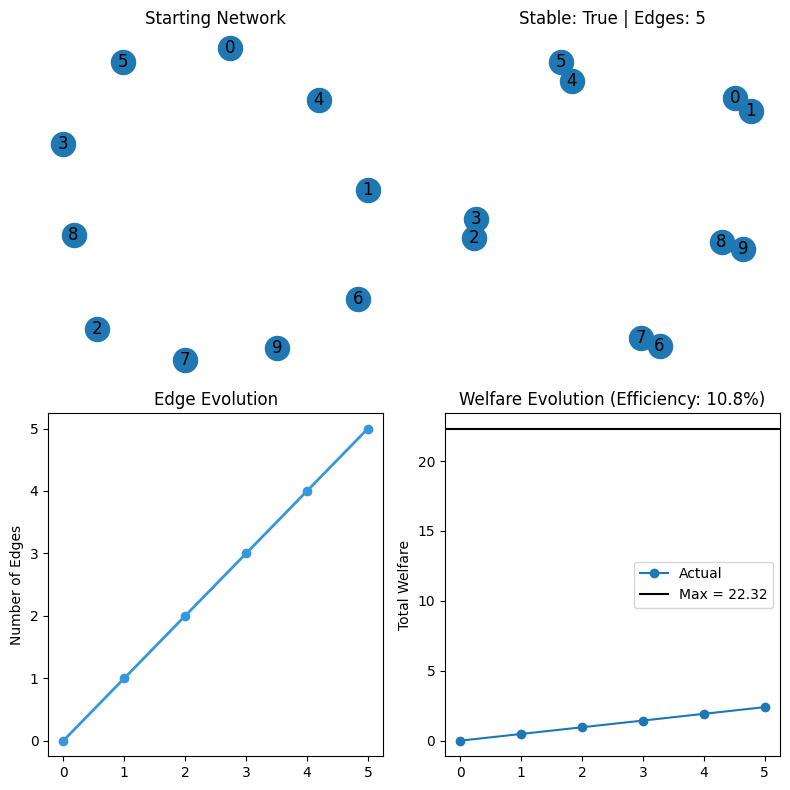

In [48]:
sim_delta = 0.5
threshold_c = sim_delta - sim_delta**2 + 0.01
plot_simulation(n=10, delta=sim_delta, c=threshold_c)

### Barbell Graph

Edge (0, 1) removed.
Edge (0, 2) removed.
Edge (0, 3) removed.
Edge (0, 4) removed.
Edge (1, 2) removed.
Edge (1, 3) removed.
Edge (1, 4) removed.
Edge (0, 1) added.
Edge (2, 3) removed.
Edge (2, 4) removed.
Edge (4, 5) removed.
Edge (6, 7) removed.
Edge (2, 5) added.
Edge (6, 8) removed.
Edge (6, 9) removed.
Edge (2, 5) removed.
Edge (6, 10) removed.
Edge (7, 8) removed.
Edge (7, 9) removed.
Edge (7, 10) removed.
Edge (2, 7) added.
Edge (8, 9) removed.
Nodes 0 and 1 are stable (action: keep)
Nodes 0 and 2 are stable (action: keep)
Nodes 0 and 3 are stable (action: keep)
Nodes 0 and 4 are stable (action: keep)
Nodes 0 and 6 are stable (action: keep)
Nodes 0 and 7 are stable (action: keep)
Nodes 0 and 8 are stable (action: keep)
Nodes 0 and 9 are stable (action: keep)
Nodes 0 and 10 are stable (action: keep)
Nodes 0 and 5 are stable (action: keep)
Nodes 1 and 0 are stable (action: keep)
Nodes 1 and 2 are stable (action: keep)
Nodes 1 and 3 are stable (action: keep)
Nodes 1 and 4 are sta

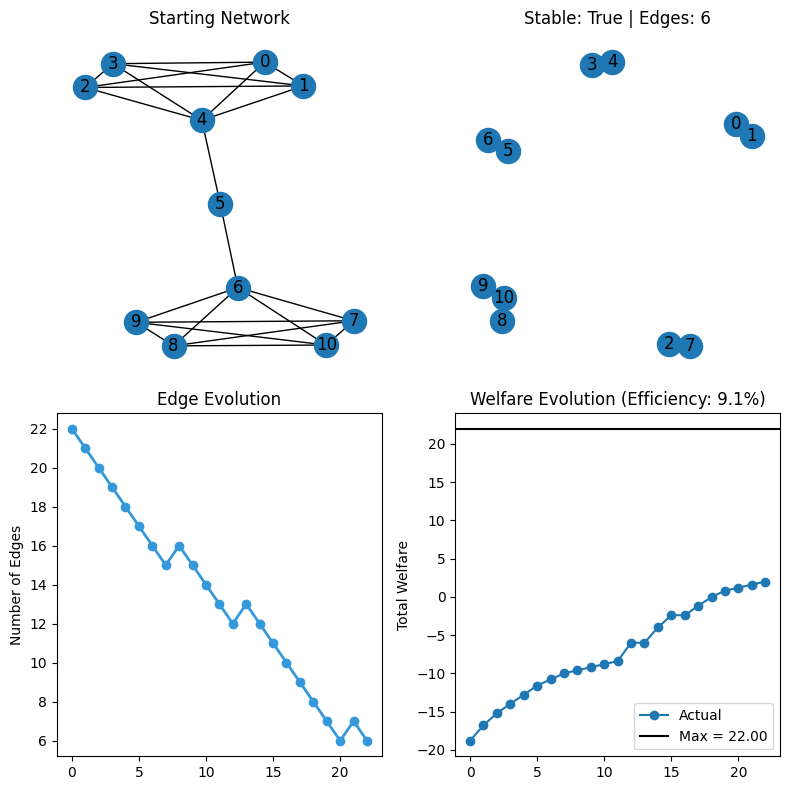

In [49]:
#barbell graph
test_graph = nx.barbell_graph(5, 1)
plot_simulation(G_init=test_graph, delta=0.4, c=0.2)

### Ring of Cliques

Edge (0, 1) removed.
Edge (0, 2) removed.
Edge (0, 3) removed.
Edge (0, 9) removed.
Edge (1, 2) removed.
Edge (1, 3) removed.
Edge (1, 4) removed.
Edge (0, 1) added.
Edge (4, 5) removed.
Edge (4, 6) removed.
Edge (4, 7) removed.
Edge (5, 6) removed.
Edge (5, 7) removed.
Edge (5, 8) removed.
Edge (4, 5) added.
Edge (8, 9) removed.
Edge (8, 10) removed.
Edge (8, 11) removed.
Edge (9, 10) removed.
Nodes 0 and 1 are stable (action: keep)
Nodes 0 and 2 are stable (action: keep)
Nodes 0 and 3 are stable (action: keep)
Nodes 0 and 4 are stable (action: keep)
Nodes 0 and 5 are stable (action: keep)
Nodes 0 and 6 are stable (action: keep)
Nodes 0 and 7 are stable (action: keep)
Nodes 0 and 8 are stable (action: keep)
Nodes 0 and 9 are stable (action: keep)
Nodes 0 and 10 are stable (action: keep)
Nodes 0 and 11 are stable (action: keep)
Nodes 1 and 0 are stable (action: keep)
Nodes 1 and 2 are stable (action: keep)
Nodes 1 and 3 are stable (action: keep)
Nodes 1 and 4 are stable (action: keep)


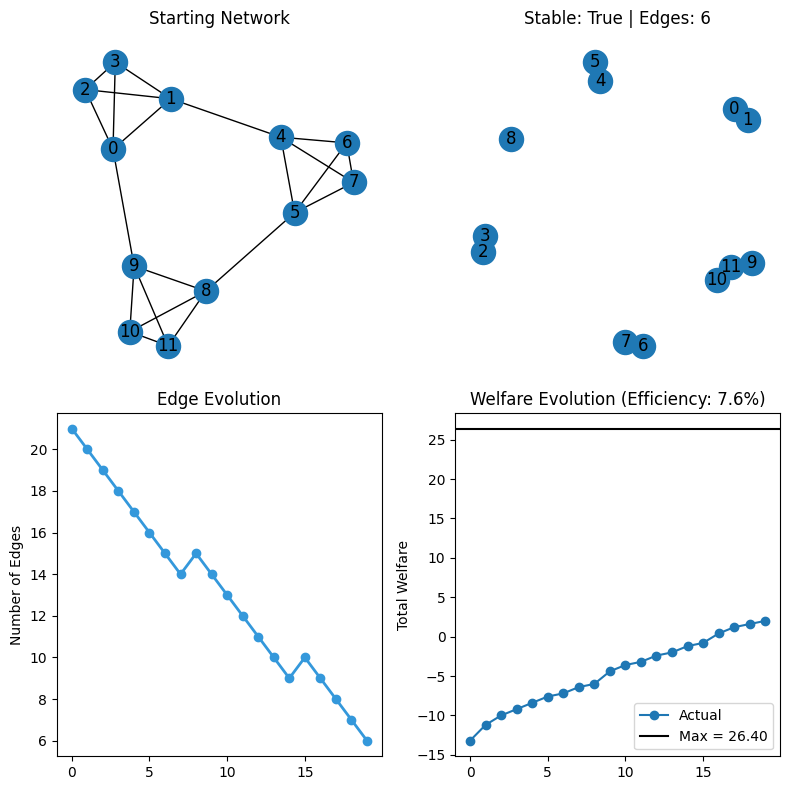

In [50]:
test_graph = nx.ring_of_cliques(3, 4)
plot_simulation(G_init=test_graph, delta=0.4, c=0.2)

### Balanced Tree


Edge (0, 1) removed.
Edge (0, 2) removed.
Edge (1, 3) removed.
Edge (1, 4) removed.
Edge (0, 1) added.
Edge (2, 5) removed.
Edge (2, 6) removed.
Nodes 0 and 1 are stable (action: keep)
Nodes 0 and 2 are stable (action: keep)
Nodes 0 and 3 are stable (action: keep)
Nodes 0 and 4 are stable (action: keep)
Nodes 0 and 5 are stable (action: keep)
Nodes 0 and 6 are stable (action: keep)
Nodes 0 and 7 are stable (action: keep)
Nodes 0 and 8 are stable (action: keep)
Nodes 0 and 9 are stable (action: keep)
Nodes 0 and 10 are stable (action: keep)
Nodes 0 and 11 are stable (action: keep)
Nodes 0 and 12 are stable (action: keep)
Nodes 0 and 13 are stable (action: keep)
Nodes 0 and 14 are stable (action: keep)
Nodes 1 and 0 are stable (action: keep)
Nodes 1 and 2 are stable (action: keep)
Nodes 1 and 3 are stable (action: keep)
Nodes 1 and 4 are stable (action: keep)
Nodes 1 and 5 are stable (action: keep)
Nodes 1 and 6 are stable (action: keep)
Nodes 1 and 7 are stable (action: keep)
Nodes 1 an

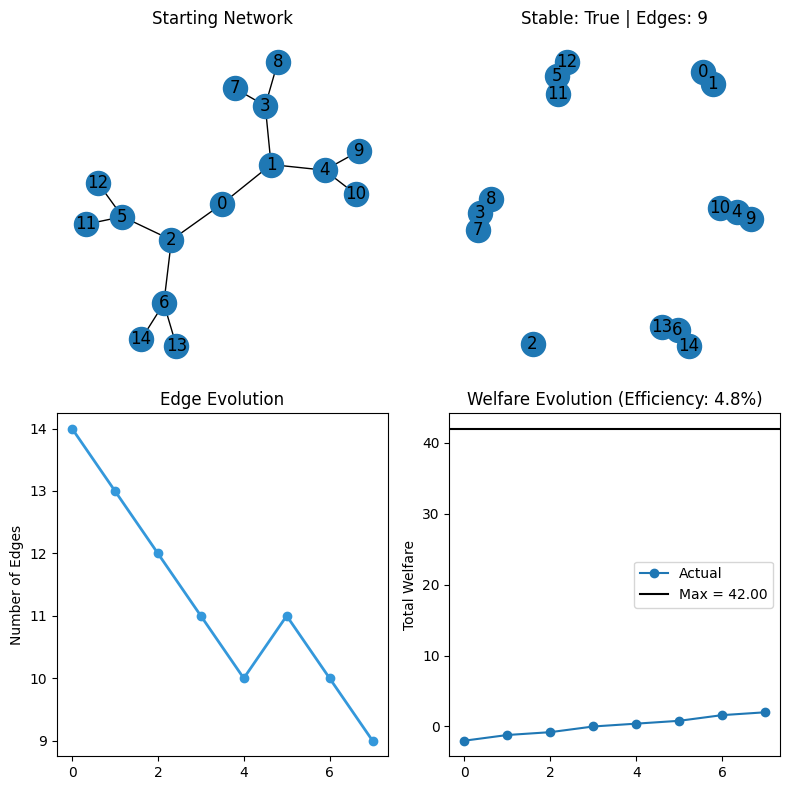

In [51]:
test_graph = nx.balanced_tree(r=2, h=3)
plot_simulation(G_init=test_graph, delta=0.4, c=0.2)